In [1]:
data = {
    0: (20, 20),
    1: (20, 40),
    2: (20, 160),
    3: (40, 120),
    4: (60, 20),
    5: (60, 80),
    6: (60, 200),
    7: (80, 180),
    8: (100, 40),
    9: (100, 120),
    10: (100, 160),
    11: (120, 80),
    12: (140, 140),
    13: (140, 180),
    14: (160, 20),
    15: (180, 60),
    16: (180, 100),
    17: (180, 200),
    18: (200, 40),
    19: (200, 160)}

In [2]:
#plot nodes
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.Graph()

for n, p in data.items():
    graph.add_node(n)
    graph.node[n]['pos'] = p
    
nx.draw_networkx(graph, data)
    
plt.axhline(y=0)
plt.axvline(x=0)
plt.grid()
plt.show()

<Figure size 640x480 with 1 Axes>

In [17]:
import random as rand

""" generate initial population """
def init_population(n):
    individuals = []
    
    for i in range(n):
        individuals.append(gen_individual())
    
    return individuals

""" generate an individual """
def gen_individual():
    nodes = list(data.keys())
    
    individual = []
    
    for i in range(len(nodes)):
        choice = rand.choice(nodes)
        nodes.remove(choice)
        individual.append(choice)
    
    return individual

""" evaluate an individual by returning its fitness score (1 / path cost)"""
def evaluate(individual):
    cost = 0
    for i in range(0, len(individual)-1):
        n1 = individual[i]
        n2 = individual[i+1]
        dist = euclid_dist(n1, n2)
        cost += dist
        
    start = individual[0]
    end = individual[len(individual)-1]
    cost += euclid_dist(end, start)
        
    return 1.0 / cost

""" select top n individuals sorted by their fitness score"""
def select_top(individuals, n):
    scores = [evaluate(i) for i in individuals]
    results = np.array(list(zip(individuals, scores)))
    return results[results[:,1].argsort()[::-1]][:n]

def tournament_selection(individuals, k):
    selection = rand.choices(individuals, k=k)
    top = select_top(selection, 1)
    
    return top[0][0]
        
""" ordered crossover """
def crossover(n1, n2):
    
    best = n1
    other = n2
    
    if evaluate(n1) < evaluate(n2):
        best = n2
        other = n1
    
    #take a random subset from the best individual
    start = rand.randint(0, len(best)-1)
    end = rand.randint(0, len(best)-1)
    
    if(start > end): #swap indices if needed
        start, end = end, start

    if(start == end): #single element
        subset = [best[start]]
        end = end+1
    else: #otherwise return subset
        subset = best[start:end]
    
    pruned_other = [x for x in other if x not in subset]
    
    new = []
    
    for i in range(0, start):
        new.append(pruned_other.pop(0))
        
    new.extend(subset)
    
    for i in range(end, len(best)):
        new.append(pruned_other.pop(0))
            
    return new

""" swap mutation """
def mutate(individual):
    gene1 = rand.randint(0, len(individual)-1)
    gene2 = rand.randint(0, len(individual)-1)
    
    while True:
        if gene1 == gene2:
            gene2 = rand.randint(0, len(individual)-1)
        else:
            break
            
    temp = individual[gene1]
    individual[gene1] = individual[gene2]
    individual[gene2] = temp
    
    return individual

def evolve(_pop, N):
    new_pop = []
    k = 25

    # add previous best to new population to guarantee the
    # fitness cannot get worse
    elite = select_top(_pop, 1)[0][0]
    new_pop.append(elite)
    N-= 1
    
    for i in range(N):
        pop = _pop.copy()
        
        # select parents
        parent1 = tournament_selection(pop, k)
        pop.remove(parent1)
        parent2 = tournament_selection(pop, k)
        
        # cross-over parents to create child
        child = crossover(parent1, parent2)
        
        # mutate child
        child = mutate(child)
        
        new_pop.append(child)
        
    return new_pop
    
""" simple euclidean distance used as cost function """
def euclid_dist(n1, n2):
    pos1 = np.array(data[n1])
    pos2 = np.array(data[n2])
    
    return np.linalg.norm(pos1-pos2)

""" creates an edgelist from a path """
def get_edges(path):
    for i in range(len(path)):
        if i == (len(path)-1): #connect end to start
            yield [path[i], path[0]]
        else:
            yield [path[i], path[i+1]]
    

fitness: 0.0005703477976201286
fitness: 0.0006571460793755282
fitness: 0.0006839395069073909
fitness: 0.0007267056139112094
fitness: 0.0007267056139112094
fitness: 0.0007692315024101478
fitness: 0.0008165554838283247
fitness: 0.0008165554838283247
fitness: 0.0008720419523793636
fitness: 0.0008720419523793636
fitness: 0.0008720419523793636
fitness: 0.0008720419523793636
fitness: 0.0008754039180853207
fitness: 0.0009032567562652317
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.0009738539633961371
fitness: 0.000975756667737496
fitness: 0.000975756667737496
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009831119295947322
fitness: 0.0009850510181166631
fitness: 0.0009850510181166631
fitness: 0

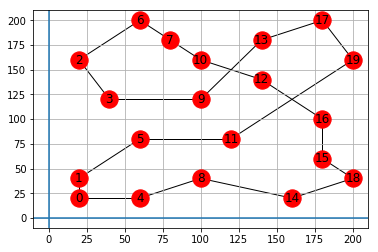

In [19]:
N = 100
iters = 20

# create initial population of individuals
individuals = init_population(N)

lastval = None
counter = 0
terminated = False

while not terminated:
# for iter in range(iters):
    new_individuals = evolve(individuals, N)
    individuals = new_individuals
    
    top = select_top(individuals, 1)[0]
    fitness = top[1]
    print("fitness:", fitness)
    
    if lastval == fitness:
        counter += 1
    else:
        counter = 0
    
    lastval = fitness
    
    if counter == iters:
        terminated = True
        
# adequate solution found
solution = select_top(individuals, 1)[0]
path = solution[0]
edges = list(get_edges(path))

print(solution)

graph = nx.Graph()

for n, p in data.items():
    graph.add_node(n)
    graph.node[n]['pos'] = p

graph.add_edges_from(edges)

nx.draw_networkx(graph, data, arrows=True)
    
plt.axhline(y=0)
plt.axvline(x=0)
plt.grid()
plt.show()